In [1]:
!nvidia-smi --list-gpus

GPU 0: NVIDIA GeForce RTX 2070 (UUID: GPU-102c475c-c1cf-442f-8c17-eff2034b5b25)


In [3]:
# Importing packages that will be used in this project

import torch
import pandas as pd
import string
import datasets
import pyarrow as pa
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from collections import Counter
from datasets import load_metric
import string
import json
import glob
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
#from google.colab import drive
from datetime import datetime
import matplotlib.ticker as mtick
from sklearn.metrics import confusion_matrix
from sklearn import feature_selection

In [4]:
import nltk
nltk.__version__
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\congc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\congc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from wordcloud import WordCloud

In [7]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import sklearn.metrics as metrics

In [8]:
import warnings                           
warnings.filterwarnings('ignore')
device = "cuda:0" if torch.cuda.is_available() else "cpu"             

In [9]:
# !mkdir -p ~/.kaggle                        # downloading and unzipping data directly from kaggle
# !cp kaggle.json ~/.kaggle/         
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d Cornell-University/arxiv
# !unzip /content/arxiv.zip               

## Data Preprocessing

In [10]:
# Read data from json
f = open('arxiv-metadata-oai-snapshot.json', 'r')
i = 0
ignores = ['comments', 'authors_parsed','authors','submitter', 'update_date','doi','report-no','versions'] # list of the data columns to drop 
record = f.readline() # start with the first record
results = []
while (record !=  ''):    
    if (i%100000) == 0:
        print("reached %s at %s"%(i,datetime.now().strftime("%d/%m/%Y %H:%M:%S")))
    res = json.loads(record) 
    version = res["versions"][0] # only choose the first versions of the data 
    res['version'] = version['version']
    res['created'] = version['created']
    for ignore in ignores: # save space
        del res[ignore]
    #data.loc[i] = res # avoid DataFrame.append(), this is too slow
    results.append(res)
    record = f.readline()  # go for the next record 
    i += 1
data = pd.DataFrame(results)

reached 0 at 17/12/2022 21:58:19
reached 100000 at 17/12/2022 21:58:20
reached 200000 at 17/12/2022 21:58:22
reached 300000 at 17/12/2022 21:58:24
reached 400000 at 17/12/2022 21:58:26
reached 500000 at 17/12/2022 21:58:28
reached 600000 at 17/12/2022 21:58:30
reached 700000 at 17/12/2022 21:58:33
reached 800000 at 17/12/2022 21:58:35
reached 900000 at 17/12/2022 21:58:37
reached 1000000 at 17/12/2022 21:58:41
reached 1100000 at 17/12/2022 21:58:44
reached 1200000 at 17/12/2022 21:58:46
reached 1300000 at 17/12/2022 21:58:49
reached 1400000 at 17/12/2022 21:58:51
reached 1500000 at 17/12/2022 21:58:54
reached 1600000 at 17/12/2022 21:58:56
reached 1700000 at 17/12/2022 21:59:01
reached 1800000 at 17/12/2022 21:59:06
reached 1900000 at 17/12/2022 21:59:07
reached 2000000 at 17/12/2022 21:59:09
reached 2100000 at 17/12/2022 21:59:11


In [11]:
data['main_categories'] = [x.split(" ")[0].split(".")[0] for x in data["categories"]] # get the main categories
data['main_categories'].unique()
print('Total number of catagories is',len(data['main_categories'].unique()))

Total number of catagories is 38


In [12]:
data.shape

(2171090, 9)

In [13]:
data["date"] = pd.to_datetime(data["created"])  # change the date into datetime format
data['year'] = pd.DatetimeIndex(data['date']).year  # choose only the years to new columns 
data['year'].unique()

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 1994, 1995, 1996, 1993, 1997, 1998,
       1999, 1992, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 1990, 1991,
       1988, 1989, 1986], dtype=int64)

In [14]:
recent_data_2015_2022 = data[(data["year"] >= 2015)&(data["year"] <= 2022)]  # choose years between 2015 to 2022
recent_data_2015_2022['journal-ref'].fillna(value=0, inplace = True)

In [16]:
# Since there are many catagories, we merged similiar catagories and reducted main_categories from 38 to 13

recent_data_2015_2022['main_categories'] = recent_data_2015_2022['main_categories'].replace("hep-ex", "hep")
recent_data_2015_2022['main_categories'] = recent_data_2015_2022['main_categories'].replace("hep-lat", "hep")
recent_data_2015_2022['main_categories'] = recent_data_2015_2022['main_categories'].replace("hep-ph", "hep")
recent_data_2015_2022['main_categories'] =recent_data_2015_2022['main_categories'].replace("hep-th", "hep")
recent_data_2015_2022['main_categories'] = recent_data_2015_2022['main_categories'].replace("math-ph", "math")
recent_data_2015_2022['main_categories'] = recent_data_2015_2022['main_categories'].replace("nucl-th", "nucl")
recent_data_2015_2022['main_categories'] = recent_data_2015_2022['main_categories'].replace("nucl-ex", "nucl")
recent_data_2015_2022['main_categories']= recent_data_2015_2022['main_categories'].replace("q-fin", "fin+econ")
recent_data_2015_2022['main_categories'] = recent_data_2015_2022['main_categories'].replace("econ", "fin+econ")
recent_data_2015_2022['main_categories']= recent_data_2015_2022['main_categories'].replace("gr-qc", "quant")
recent_data_2015_2022['main_categories'] = recent_data_2015_2022['main_categories'].replace("quant-ph", "quant")

In [17]:
recent_data_2015_2022['accept'] = recent_data_2015_2022['journal-ref']!=0 

In [18]:
print('Total number of catagories reduce to',len(recent_data_2015_2022['main_categories'].unique()))

Total number of catagories reduce to 13


In [19]:
recent_data_2015_2022['main_categories'].unique()

array(['math', 'cond-mat', 'q-bio', 'hep', 'physics', 'nlin', 'astro-ph',
       'cs', 'stat', 'fin+econ', 'quant', 'nucl', 'eess'], dtype=object)

In [20]:
# count the number of articles by different categories in each year. 
cumulative_by_catagory = recent_data_2015_2022.groupby(["year", 'main_categories'])[["id"]].count().reset_index().pivot_table(index=["year"], columns=['main_categories']).fillna(0).cumsum()

In [21]:
cumulative_by_catagory['id'].T

year,2015,2016,2017,2018,2019,2020,2021,2022
main_categories,,,,,,,,
astro-ph,12893,26110,39378,53441,67861,82698,97160,110616
cond-mat,13925,28547,42965,57675,72888,89071,105222,119526
cs,16198,36959,64033,99909,143836,197986,258957,318912
eess,5,8,444,2790,8343,17684,25756,33965
fin+econ,694,1445,2219,3400,4862,6900,9120,11056
hep,10111,19798,29397,38975,48669,58166,68393,77895
math,28663,58653,90313,123696,158723,195475,230991,263853
nlin,792,1601,2472,3227,4057,4941,5727,6400
nucl,1762,3588,5293,7053,8770,10523,12058,13558


### Data Visualization

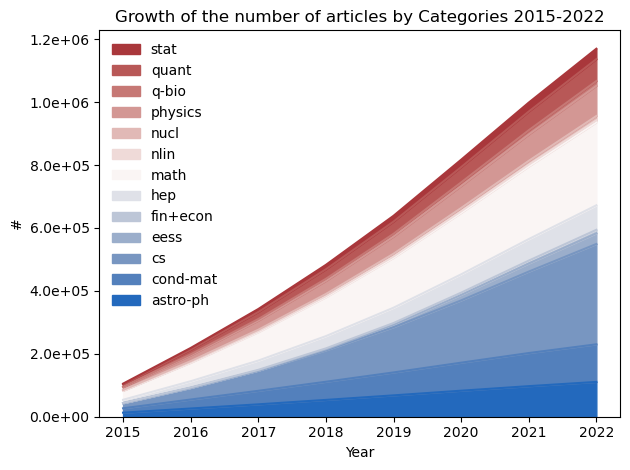

In [22]:
cumulative_by_catagory['id'].plot.area(cmap="vlag")
plt.title("Growth of the number of articles by Categories 2015-2022")
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.xticks([2015+x for x in range(2022-2015+1)])
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::-1], labels[::-1], frameon=False)
plt.xlabel("Year") 
plt.ylabel("#") 
plt.tight_layout()
plt.show()

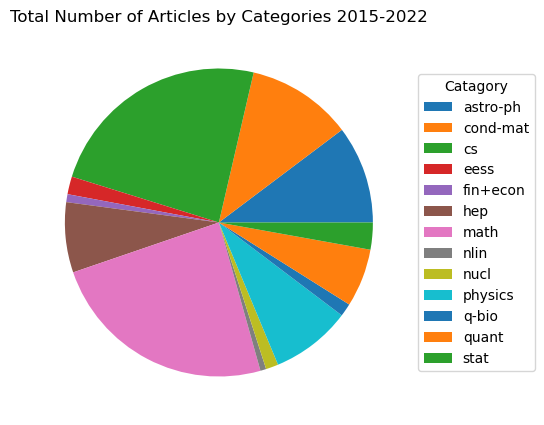

In [23]:
# plot pie chart to visualize number of articles by different categories
pie_plot = cumulative_by_catagory['id'].sum(axis=0)
plt.figure(figsize=[5,5])
plt.title("Total Number of Articles by Categories 2015-2022")
plt.pie(pie_plot)
plt.legend(cumulative_by_catagory['id'].sum(axis=0).index, 
          title="Catagory",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

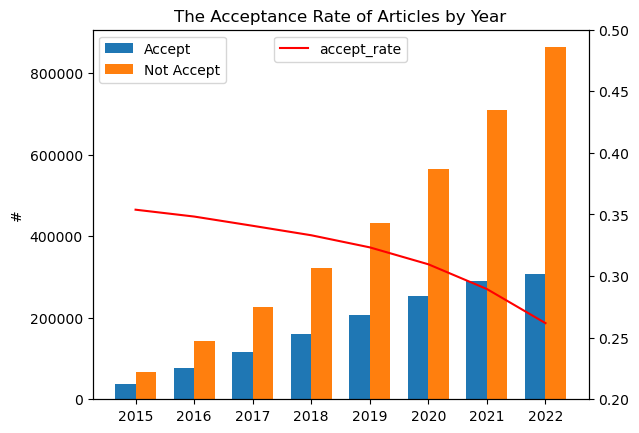

In [24]:
# count the number of articles accept or doesn't accepts to publish in journal by year. 
cumulative_accepence = recent_data_2015_2022.groupby(["year", 'accept'])[["id"]].count().reset_index().pivot_table(index=["year"], columns=['accept']).fillna(0).cumsum()
accept = list(cumulative_accepence['id'].iloc[:,1])
not_accept = list(cumulative_accepence['id'].iloc[:,0])
graph_label = list(cumulative_accepence['id'].iloc[:,1].index)
x = np.arange(len(graph_label))
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.35/2, accept, 0.35, label='Accept')
rects2 = ax.bar(x + 0.35/2, not_accept , 0.35, label='Not Accept')
ax2 = ax.twinx()
rects3 = ax2.plot(list(cumulative_accepence['id'].iloc[:,1] / (cumulative_accepence['id'].iloc[:,0]+cumulative_accepence['id'].iloc[:,1])) , '-r', label = 'accept_rate')
ax.set_ylabel('#')
ax.set_title('The Acceptance Rate of Articles by Year')
ax.set_xticks(x)
ax.set_xticklabels(graph_label)
ax2.set_xticklabels(graph_label)
ax2.set_ylim(0.2,0.5)
ax.legend()
ax2.legend(loc='upper center')

In [25]:
# only take the data in 2022 to test models
#recent_data = recent_data_2015_2022[(recent_data_2015_2022["year"] >= 2021)&(recent_data_2015_2022["year"] <= 2022)]
recent_data = recent_data_2015_2022[recent_data_2015_2022["year"] == 2022]

In [26]:
recent_data1 = recent_data[['id','title','abstract','journal-ref','main_categories','accept','year']]
data_dropna = recent_data1[recent_data1['journal-ref']!=0]
shorten_journal_title = []
for journal_title in data_dropna['journal-ref']:
  j = ''.join([c for c in journal_title if c in string.ascii_letters])    #cleaning journal-ref to lables for prediction 
  if j.startswith('PhysRev'):
    j = 'PhysRev'
  shorten_journal_title.append(j)
data_dropna['shorten_journal_title'] = shorten_journal_title

data_dropna['text'] = data_dropna['title'] + data_dropna['abstract']

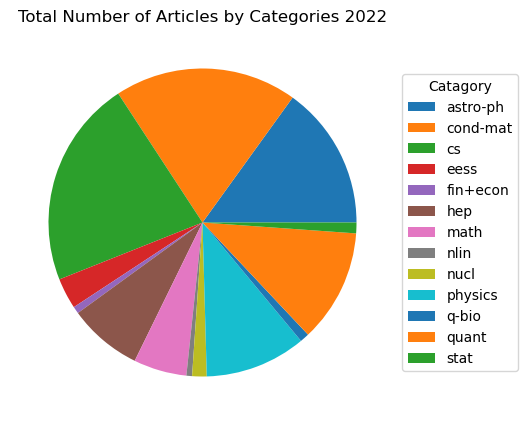

In [27]:
# plot pie chart to visualize number of articles by differe categories (2022 only)
cumulative = data_dropna.groupby(["year", 'main_categories'])[["id"]].count().reset_index().pivot_table(index=["year"], columns=['main_categories']).fillna(0).cumsum()
pie_plot = cumulative['id'].sum(axis=0)
plt.figure(figsize=[5,5])
plt.title("Total Number of Articles by Categories 2022")
plt.pie(pie_plot)
plt.legend(cumulative_by_catagory['id'].sum(axis=0).index, 
          title="Catagory",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [28]:
data_dropna.shape

(17205, 9)

In [29]:
data_dropna.head()

,id,title,abstract,journal-ref,main_categories,accept,year,shorten_journal_title,text
1585457,2201.00085,Strong quantum nonlocality for unextendible pr...,A set of multipartite orthogonal product sta...,Journal of Physics A: Mathematical and Theoret...,quant,True,2022,JournalofPhysicsAMathematicalandTheoretical,Strong quantum nonlocality for unextendible pr...
1585465,2201.00093,Distributed Evolution Strategies Using TPUs fo...,Meta-learning traditionally relies on backpr...,2020 IEEE Symposium Series on Computational In...,cs,True,2022,IEEESymposiumSeriesonComputationalIntelligence...,Distributed Evolution Strategies Using TPUs fo...
1585485,2201.00113,Electronic and Optical properties of Metallic ...,The electronic and the optical properties of...,"Solid State Communications 346, 114705 (2022)",cond-mat,True,2022,SolidStateCommunications,Electronic and Optical properties of Metallic ...
1585487,2201.00115,Toward the Analysis of Graph Neural Networks,Graph Neural Networks (GNNs) have recently e...,The 44th IEEE/ACM International Conference on ...,cs,True,2022,ThethIEEEACMInternationalConferenceonSoftwareE...,Toward the Analysis of Graph Neural Networks ...
1585489,2201.00117,Usability and Aesthetics: Better Together for ...,With the recent explosive growth of mobile d...,2021 IEEE 32nd International Symposium on Soft...,cs,True,2022,IEEEndInternationalSymposiumonSoftwareReliabil...,Usability and Aesthetics: Better Together for ...


### Preparing data for Naive Bayes Model

In [30]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
:return
    cleaned text
'''
def preprocess_text(text, lst_stopwords=None):
   text = re.sub(r'[^\w\s]', '', str(text).lower().strip())  # remove all special character, punctuation and spaces from string
   lst_text = text.split()   
   if lst_stopwords is not None:
       lst_text = [word for word in lst_text if word not in
                   lst_stopwords]

   text = " ".join(lst_text)
   return text

stopwords = nltk.corpus.stopwords.words("english")
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [31]:
data_dropna["text_clean"] = data_dropna["text"].apply(lambda x: preprocess_text(x, lst_stopwords=stopwords))

In [32]:
'''
Preprocess a series.
:parameter
    :param content: series - containing text
:return
    list of total words in the series components
'''
def tokenized_content(content): 
  r = []
  for t in content:
    tokens = nltk.word_tokenize(t)
    tokens = [token.lower() for token in tokens if (token.lower() not in stopwords) and (token.isalpha())]
    r.extend(tokens)
  return r

In [33]:
words = tokenized_content(data_dropna['text_clean'])

In [34]:
top_common = Counter(words).most_common()
top_most_common = top_common[0:20]        # count the most common words in the word list. 

In [35]:
top_most_common

[('model', 9769),
 ('quantum', 7934),
 ('using', 7840),
 ('data', 7720),
 ('results', 6428),
 ('also', 5928),
 ('two', 5585),
 ('show', 5457),
 ('study', 5161),
 ('system', 5115),
 ('models', 5069),
 ('field', 4973),
 ('based', 4857),
 ('systems', 4814),
 ('different', 4808),
 ('energy', 4606),
 ('magnetic', 4412),
 ('method', 4369),
 ('new', 4148),
 ('time', 4032)]

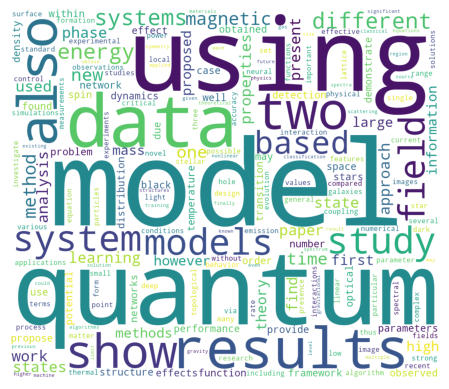

In [36]:
# create graphs base on words' frequency
wc1 = WordCloud(background_color = 'white', width=1000, height = 860, margin =2).generate_from_frequencies(Counter(words))
plt.imshow(wc1)
plt.axis('off')
plt.show()

In [37]:
# machine learning models
data_dropna_train, data_dropna_test = model_selection.train_test_split(data_dropna, test_size=0.3) #split data
y_train = data_dropna_train["main_categories"].values
y_test = data_dropna_test["main_categories"].values
x_train =data_dropna_train["text_clean"].values
x_test =  data_dropna_test["text_clean"].values

In [38]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=8000, ngram_range=(1,2)) # count the frequencies with maximum 8000 features

In [39]:
corpus =x_train
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [40]:
#feature selection: we want to drop some columns and reduce dimensionality of features.  
#The Chi-Square test and hypothesis testing is implemented to test the independence and avoid collinearity
y = y_train
p_value= 0.95
new_features = pd.DataFrame()
X_names = vectorizer.get_feature_names()
for category in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==category)         # featire selection basek on Chi-Square test
    new_features = new_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":category}))
    new_features = new_features.sort_values(["y","score"], ascending=[True,False])
    new_features = new_features[new_features["score"]>p_value]
X_names = new_features["feature"].unique().tolist()

In [41]:
# reduced the total features
features_total = 0
for category in np.unique(y):
   features_total += len(new_features[new_features["y"]==category])
   print(format(category))
   print("Number of Features Selected:",len(new_features[new_features["y"]==category]))
   print("The Top Features:", ",".join(new_features[new_features["y"]==category]["feature"].values[:5]))

astro-ph
Number of Features Selected: 1069
The Top Features: accretion,agn,disk,dust,dwarf
cond-mat
Number of Features Selected: 1046
The Top Features: antiferromagnetic,electronic,fermi,ferromagnetic,films
cs
Number of Features Selected: 1411
The Top Features: datasets,language,learning,semantic,task
eess
Number of Features Selected: 241
The Top Features: chest,concealment,ct,segmentation,video
fin+econ
Number of Features Selected: 124
The Top Features: capital,credit,economic,equity,financial
hep
Number of Features Selected: 413
The Top Features: axion,boson,branching,decay,decays
math
Number of Features Selected: 283
The Top Features: algebra,algebras,banach,let,polynomials
nlin
Number of Features Selected: 85
The Top Features: chaotic,integrable,oscillators,synchronization,hierarchy
nucl
Number of Features Selected: 180
The Top Features: collisions,eos,heavyion,heavyion collisions,isospin
physics
Number of Features Selected: 235
The Top Features: laser,metasurfaces,optical,beam,rey

In [42]:
print('The total features are reduced to', features_total)

The total features are reduced to 5794


In [43]:
# trasform based on new number of features, Smaller features matrix with a short vocabulary is made. 
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

Text(0.5, 1.0, 'Sparse Matrix')

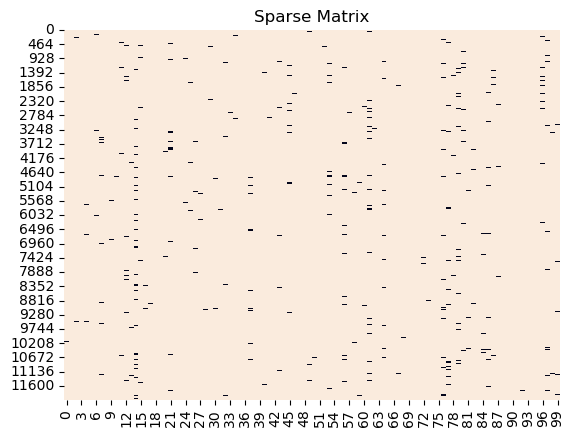

In [44]:
# visualized the smaller matrix of features
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix')

In [45]:
X_names = new_features["feature"].unique().tolist()

## Model Training

### Naive Bayes Model Training

In [46]:
#train and predict the with a probabilic Naive Bayes classifier, using probability to predict y test variable. 
classifier = naive_bayes.MultinomialNB()
model_bays = pipeline.Pipeline([("vectorizer", vectorizer),  ("classifier", classifier)])
model_bays["classifier"].fit(X_train, y_train)
predicted = model_bays.predict(x_test)
predicted_probaility = model_bays.predict_proba(x_test)

In [47]:
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_probaility,multi_class="ovr")
print("The accuracy based on the naive bayes model is:", round(accuracy,4))
print("The AUC based on the naive bayes model is:", round(auc,4))

The accuracy based on the naive bayes model is: 0.7464
The AUC based on the naive bayes model is: 0.9406


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0.5, 0, 'astro-ph'),
  Text(1.5, 0, 'cond-mat'),
  Text(2.5, 0, 'cs'),
  Text(3.5, 0, 'eess'),
  Text(4.5, 0, 'fin+econ'),
  Text(5.5, 0, 'hep'),
  Text(6.5, 0, 'math'),
  Text(7.5, 0, 'nlin'),
  Text(8.5, 0, 'nucl'),
  Text(9.5, 0, 'physics'),
  Text(10.5, 0, 'q-bio'),
  Text(11.5, 0, 'quant'),
  Text(12.5, 0, 'stat')])

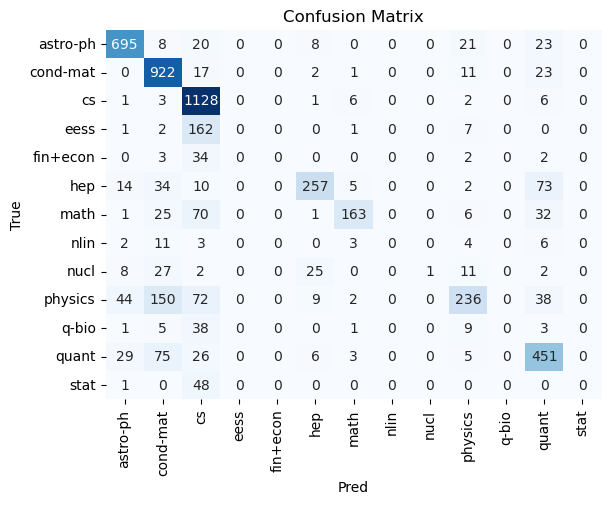

In [48]:
#ploting the confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)

classes = np.unique(y_test)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion Matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)


In [49]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

    astro-ph       0.87      0.90      0.88       775
    cond-mat       0.73      0.94      0.82       976
          cs       0.69      0.98      0.81      1147
        eess       0.00      0.00      0.00       173
    fin+econ       0.00      0.00      0.00        41
         hep       0.83      0.65      0.73       395
        math       0.88      0.55      0.67       298
        nlin       0.00      0.00      0.00        29
        nucl       1.00      0.01      0.03        76
     physics       0.75      0.43      0.54       551
       q-bio       0.00      0.00      0.00        57
       quant       0.68      0.76      0.72       595
        stat       0.00      0.00      0.00        49

    accuracy                           0.75      5162
   macro avg       0.50      0.40      0.40      5162
weighted avg       0.71      0.75      0.71      5162



In [53]:

def evaluate_graphs(y_test, predicted, predicted_prob, figsize=(15,5)):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="ROC Curve")
    ax[0].legend(loc="lower right",prop={'size': 8})
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="lower left",prop={'size': 8})
    ax[1].grid(True)
    plt.show()

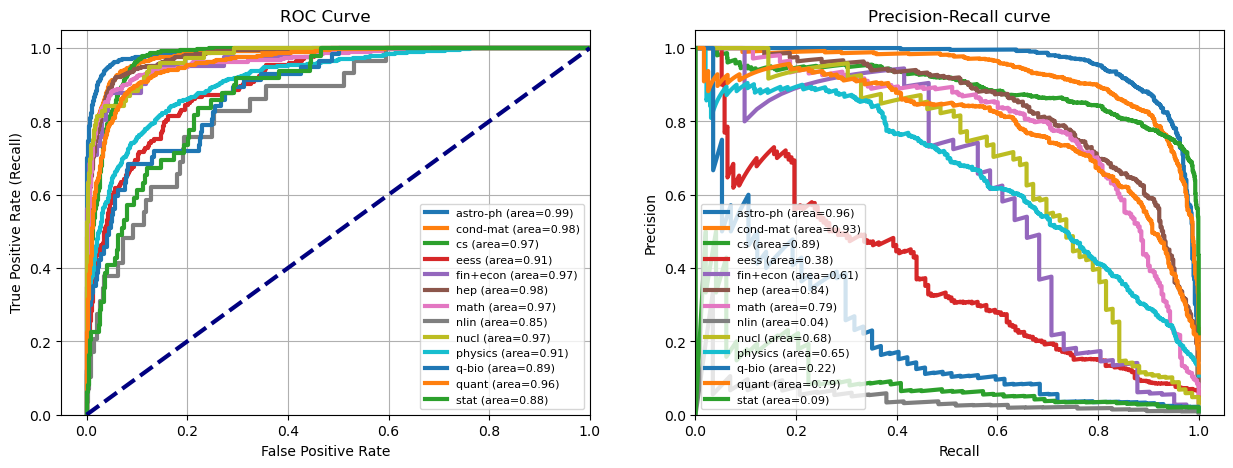

In [54]:
evaluate_graphs(y_test, predicted, predicted_probaility, figsize=(15,5))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)


### Neural based Model Training

In [ ]:
# Get accuracy as metric for evaluation

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    #print(predictions, labels)
    return metric.compute(predictions=predictions, references=labels)

# Data preprocessing for neural based model
def data_preprocessing(data_dropna, label_column='shorten_journal_title', feature='title', TOP_N = 2):
    counter = Counter(data_dropna[label_column].to_list())
    
    # use top-N labels as our target
    
    pred_title_list = [title for title, cnt in counter.most_common()[:TOP_N]]
    print(pred_title_list)
    
    # convert text labels into ids
    text_list = []
    title2idx = {}
    max_idx = 0
    label_list = []
    for title, text in zip(data_dropna[label_column].to_list(), data_dropna[feature].to_list()):
        if title not in pred_title_list:
            continue
        if title not in title2idx:
            title2idx[title] = max_idx
            max_idx += 1

        label_list.append(title2idx[title])
        text_list.append(text)

    data_df = pd.DataFrame({
        'text': text_list,
        'label': label_list
    })

    data_df = data_df.sample(frac=1).reset_index()

    # Training and testing data split
    
    train_num = int(len(data_df)*0.7)
    test_num = len(data_df) - train_num

    train_data_df = data_df[:train_num]
    test_data_df = data_df[-test_num:]

    # Build training and testing data
    train_dataset = datasets.Dataset(pa.Table.from_pandas(train_data_df))
    test_dataset = datasets.Dataset(pa.Table.from_pandas(test_data_df))
    dd = datasets.DatasetDict({
        'train': train_dataset,
        'test': test_dataset
    })

    return dd, max_idx, title2idx

# Neural based Model Training
def train(dd, device=None, include_na=False, lr=2e-5, batch_size=64, eval_batch_size=16, weight_decay=0.01, epochs=50, max_idx = 13):

    # tokenize both training and testing text
    tokenized_dd = dd.map(preprocess_function, batched=True)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    # use distillbert as our pretraining model
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=max_idx)
    if device is not None:
        model = model.to(device)
        
    # support Apple M1 chip GPU acceleration
    class TrainingArgumentsWithMPSSupport(TrainingArguments):
        @property
        def device(self) -> torch.device:
            if torch.cuda.is_available():
                return torch.device("cuda")
            elif torch.backends.mps.is_available():
                return torch.device("mps")
            else:
                return torch.device("cpu")
    
    # setting training arguments
    training_args = TrainingArgumentsWithMPSSupport(
        output_dir="./results",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=eval_batch_size,
        num_train_epochs=epochs,
        weight_decay=weight_decay,
        evaluation_strategy="epoch",
        save_steps=99999999,
    )
    
    # build trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dd["train"],
        eval_dataset=tokenized_dd["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    return trainer, model, tokenized_dd, data_collator

/var/folders/g0/1l36nm8d4rz25wb0sc99g3hc0000gn/T/ipykernel_52647/2791274390.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
# Callig data preprocessing for category prediction using neural model
dd, max_id, title2idx = data_preprocessing(data_dropna, 'main_categories', 'text_clean',13)
print(dd)

['cs', 'cond-mat', 'astro-ph', 'quant', 'physics', 'hep', 'math', 'eess', 'nucl', 'stat', 'q-bio', 'fin+econ', 'nlin']
DatasetDict({
    train: Dataset({
        features: ['index', 'text', 'label'],
        num_rows: 10169
    })
    test: Dataset({
        features: ['index', 'text', 'label'],
        num_rows: 4359
    })
})


In [ ]:
# Callig model training for category prediction using neural model
trainer1, model1, tokenized_dd1, data_collator1 = train(dd, device=device, lr=2e-6, batch_size=8, eval_batch_size=4, weight_decay=0.01, epochs=10)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos

Epoch,Training Loss,Validation Loss,Accuracy
1,1.591700,1.285568,0.625832
2,1.085800,0.986899,0.718743
3,0.934300,0.882219,0.735490
4,0.836500,0.839719,0.738013
5,0.793200,0.798908,0.748107
6,0.736600,0.775608,0.750172
7,0.712100,0.757636,0.753384
8,0.681000,0.752039,0.755448
9,0.676800,0.748663,0.757054
10,0.657900,0.743656,0.761184


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, index. If text, index are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4359
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, index. If text, index are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4359
  Batch size = 4
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, index. If text, index are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Ru

In [ ]:
# Model inference
pred, label, metrics = trainer1.predict(tokenized_dd1['test'])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text, index. If text, index are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4359
  Batch size = 4


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0.5, 0, 'quant'),
  Text(1.5, 0, 'cs'),
  Text(2.5, 0, 'cond-mat'),
  Text(3.5, 0, 'math'),
  Text(4.5, 0, 'astro-ph'),
  Text(5.5, 0, 'fin+econ'),
  Text(6.5, 0, 'physics'),
  Text(7.5, 0, 'hep'),
  Text(8.5, 0, 'nucl'),
  Text(9.5, 0, 'eess'),
  Text(10.5, 0, 'q-bio'),
  Text(11.5, 0, 'nlin'),
  Text(12.5, 0, 'stat')])

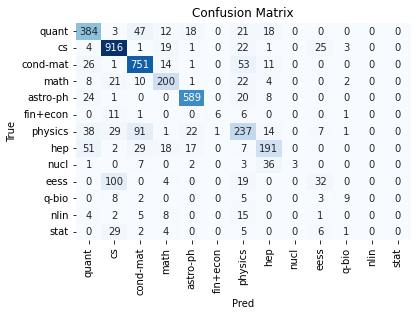

In [ ]:
# Results visualization
# Show confusion matrix for neural based model
labels_cm = title2idx.keys()
classes = title2idx.keys()
confusion_matrix_df = pd.DataFrame(confusion_matrix(list(label),list(pred.argmax(1))))
confusion_matrix_df.columns =  ['a' for i in range(13)]
confusion_matrix_df.index =  ['a' for i in range(13)]
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix_df, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion Matrix")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

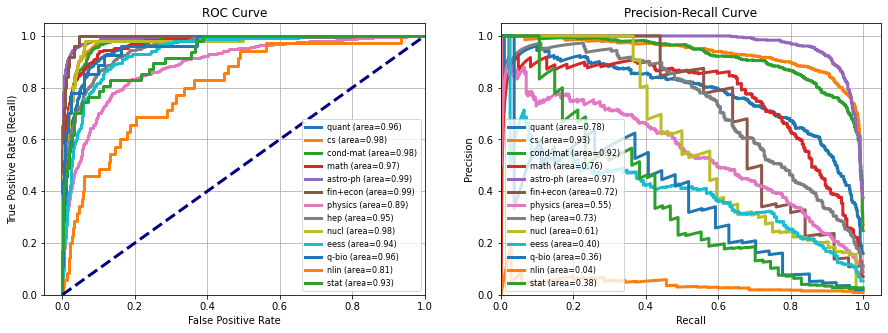

In [ ]:
# Visualize ROC Curve and PR Curve
titles = list(title2idx.keys())
evaluate_graphs(list(label),list(pred.argmax(1)), pred, figsize=(15,5), titles=titles)

In [ ]:
# Predict acceptance from paper title
# We run it in another colab job since it needs more than one hour to get the results.
# We get accuracy of 61.5% in the end
dd, max_idx, title2idx = data_preprocessing(mix_data, 'shorten_journal_title', 'title', TOP_N=2)
print(dd)

trainer, tokenized_dd = train(dd, device=device, epochs=15)

In [ ]:
# predict acceptance from paper abstract
# We run it in another colab job since it needs more than one hour to get the results.
# We get accuracy of 66.1% in the end

dd, max_idx, title2idx = data_preprocessing(mix_data, 'shorten_journal_title', 'abstract', TOP_N=2)
print(dd)

trainer, tokenized_dd = train(dd, device=device, lr=2e-6, batch_size=8, eval_batch_size=4, weight_decay=0.01, epochs=7)

In [ ]:
# predict journal title from paper title
# We run it in another colab job since it needs more than one hour to get the results.
# We get accuracy of 64.1% in the end

dd, max_idx, title2idx = data_preprocessing(data_dropna_100k, 'shorten_journal_title', 'title', 15)
print(dd)

trainer, tokenized_dd = train(dd, device=device, epochs=15)

In [ ]:
# predict journal title from paper abstract
# We run it in another colab job since it needs more than one hour to get the results.
# We get accuracy of 66.7% in the end

dd, max_idx, title2idx = data_preprocessing(data_dropna_100k, 'shorten_journal_title', 'abstract', 15)
print(dd)

trainer, tokenized_dd = train(dd, device=device, lr=1e-5, batch_size=8, eval_batch_size=4, weight_decay=0.01, epochs=7)